In [ ]:
"""
1. Look at spatial distribution of last sold properties
"""

In [3]:
from datetime import datetime
import matplotlib
import matplotlib as mpl
import requests
import json
from gql import gql, Client
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from gql.transport.requests import RequestsHTTPTransport
# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://api.thegraph.com/subgraphs/name/decentraland/marketplace")
# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

In [4]:
## Query string used to get Genesis plazas, owner is "0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce"
mystring = """
            {{
                estates(first: 1, orderBy: id, where: {{owner: "0x4eac6325e1dbf1ac90434d39766e164dca71139e", id_gt:"{0}"}}) {{
                    id
                    parcels(first: 1000, orderBy: id, where: {{id_gt:"{1}"}}) {{
                      id
                      x
                      y
                    }}
                  }}
            }}"""

In [16]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
estate_max = 0
e_count = 0

for i in range(8):
    #For a given estate, get all parcels
    parcel_max = 0
    p_count = 0
    dfn = pd.DataFrame()
    
    query = gql(mystring.format(estate_max, parcel_max))
    result = client.execute(query)
    #if there is no data returned it means you reached the end and should stop querying.
    if len(result['estates']) < 1:
        break
    
    while True:
        #query the data using GraphQL python library.
        query = gql(mystring.format(estate_max, parcel_max))
        result = client.execute(query)
        
        if len(result['estates'][0]['parcels']) < 1:
            break
        else:
            #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
            eid = [result['estates'][0]['id'] for e in result['estates'][0]['parcels']]
            pid = [p['id'] for p in result['estates'][0]['parcels'] ]
            x = [int(p['x']) for p in result['estates'][0]['parcels'] ]
            y = [int(p['y']) for p in result['estates'][0]['parcels'] ]

            dfnn = pd.DataFrame({'eid':eid,'pid':pid,'x':x,'y':y})
            dfn = dfn.append(dfnn, ignore_index=True)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        p_count += len(result['estates'][0]['parcels'])
        parcel_max = dfn['pid'].max()
    
    df = df.append(dfn, ignore_index=True)
    estate_max = df['eid'].max()
    e_count +=1
    print(f'estate {e_count} done, {p_count} parcels found')


df.to_csv('genesis.csv',index=False)

estate 1 done, 400 parcels found
estate 2 done, 400 parcels found
estate 3 done, 400 parcels found
estate 4 done, 400 parcels found
estate 5 done, 400 parcels found
estate 6 done, 400 parcels found
estate 7 done, 400 parcels found
estate 8 done, 400 parcels found


(0.0, 100.0, 0.0, 101.0)

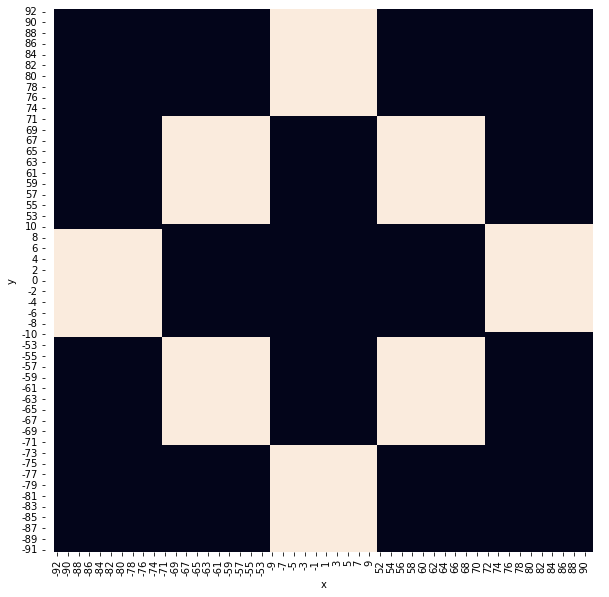

In [38]:
genesis = pd.read_csv('genesis.csv')
genesis_map = ~genesis.pivot("y", "x",'pid').isna()
plt.figure(figsize=(10,10))
plot = sns.heatmap(genesis_map, square = True, cbar =False)
plt.gca().invert_yaxis()
#plt.xlim([-150,150])
#plt.ylim([-150,150])
plt.gca().axis('equal')

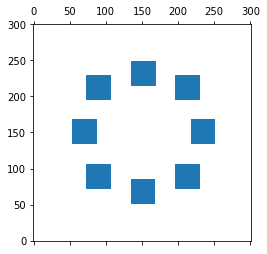

In [38]:
from scipy.sparse import coo_matrix
test = coo_matrix((np.ones(len(genesis)), (genesis.x + 151, genesis.y + 151)), shape=(301, 301))
plt.spy(test)
plt.gca().invert_yaxis()
#plt.gca().set_xlim(xmin=-150, xmax=150)

In [254]:
## Query string used to get roads, owner is "0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce"
mystring = """
            {{
                estates(first: 1, orderBy: id, where: {{owner: "0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce", id_gt:"{0}"}}) {{
                    id
                    parcels(first: 1000, orderBy: id, where: {{id_gt:"{1}"}}) {{
                      id
                      x
                      y
                    }}
                  }}
            }}"""

In [256]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
estate_max = 0
e_count = 0

while True:
    #For a given estate, get all parcels
    parcel_max = 0
    p_count = 0
    dfn = pd.DataFrame()
    
    query = gql(mystring.format(estate_max, parcel_max))
    result = client.execute(query)
    #if there is no data returned it means you reached the end and should stop querying.
    if len(result['estates']) < 1:
        break
    
    while True:
        #query the data using GraphQL python library.
        query = gql(mystring.format(estate_max, parcel_max))
        result = client.execute(query)
        
        if len(result['estates'][0]['parcels']) < 1:
            break
        else:
            #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
            eid = [result['estates'][0]['id'] for e in result['estates'][0]['parcels']]
            pid = [p['id'] for p in result['estates'][0]['parcels'] ]
            x = [int(p['x']) for p in result['estates'][0]['parcels'] ]
            y = [int(p['y']) for p in result['estates'][0]['parcels'] ]

            dfnn = pd.DataFrame({'eid':eid,'pid':pid,'x':x,'y':y})
            dfn = dfn.append(dfnn, ignore_index=True)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        p_count += len(result['estates'][0]['parcels'])
        parcel_max = dfn['pid'].max()
    
    df = df.append(dfn, ignore_index=True)
    estate_max = df['eid'].max()
    e_count +=1
    print(f'estate {e_count} done, {p_count} parcels found')


df.to_csv('roads.csv',index=False)

estate 1 done, 172 parcels found
estate 2 done, 1110 parcels found
estate 3 done, 557 parcels found
estate 4 done, 406 parcels found
estate 5 done, 743 parcels found
estate 6 done, 581 parcels found
estate 7 done, 799 parcels found
estate 8 done, 289 parcels found
estate 9 done, 1244 parcels found
estate 10 done, 480 parcels found
estate 11 done, 10 parcels found
estate 12 done, 701 parcels found
estate 13 done, 730 parcels found
estate 14 done, 162 parcels found
estate 15 done, 1454 parcels found


In [305]:
import get_marketplace_data as gmd

In [327]:
import importlib
importlib.reload(gmd)

<module 'get_marketplace_data' from '/home/jovyan/datacourse/Decentraland_playground/get_marketplace_data.py'>

In [328]:
gmd.get_parcels_from_estate('roads','0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce')

estate 1 done, 172 parcels found
estate 2 done, 1110 parcels found
estate 3 done, 557 parcels found
estate 4 done, 406 parcels found
estate 5 done, 743 parcels found
estate 6 done, 581 parcels found
estate 7 done, 799 parcels found
estate 8 done, 289 parcels found
estate 9 done, 1244 parcels found
estate 10 done, 480 parcels found
estate 11 done, 10 parcels found
estate 12 done, 701 parcels found
estate 13 done, 730 parcels found
estate 14 done, 162 parcels found
estate 15 done, 1454 parcels found


In [330]:
gmd.get_parcels_from_estate('genesis','0x4eac6325e1dbf1ac90434d39766e164dca71139e',8)

estate 1 done, 400 parcels found
estate 2 done, 400 parcels found
estate 3 done, 400 parcels found
estate 4 done, 400 parcels found
estate 5 done, 400 parcels found
estate 6 done, 400 parcels found
estate 7 done, 400 parcels found
estate 8 done, 400 parcels found


In [331]:
roads = pd.read_csv('roads.csv')

(0.0, 301.0, 0.0, 301.0)

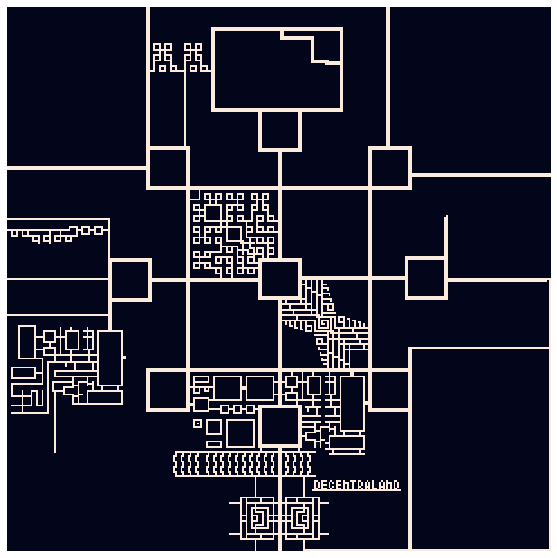

In [332]:
road_map = ~roads.pivot("y", "x",'pid').isna()
plt.figure(figsize=(10,10))
plot = sns.heatmap(road_map, square = True, cbar =False)
plt.gca().invert_yaxis()
plt.gca().axis('off')

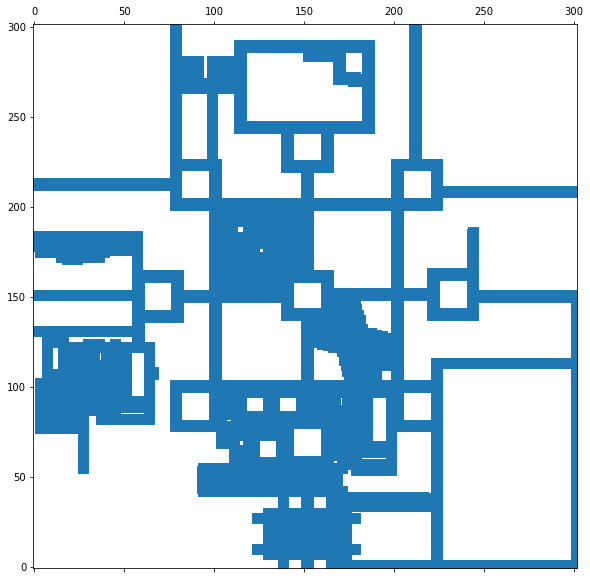

In [44]:
from scipy.sparse import coo_matrix
plt.figure(figsize=(10,10))
test = coo_matrix((np.ones(len(roads)), (roads.y + 151, roads.x + 151)), shape=(302, 302))
plt.spy(test)
plt.gca().invert_yaxis()
#plt.gca().set_xlim(xmin=-150, xmax=150)

In [45]:
## Query string used to get latest parcel transaction information
mystring = """
{{
  orders (first: 1000 orderBy: updatedAt, orderDirection: asc where: {{ status:sold category:parcel updatedAt_gt:"{0}"}}, subgraphError: allow) {{
 
 
    category
    status
    price
    id
    updatedAt
    nft {{
      owner {{
        id
      }}
      name
      estate {{
        id
      }}
      parcel {{
        id
        x
        y
      }}
     
      owner {{
        id
      }}
    }}
   
  }}
 
}}"""

In [46]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
update = 1

while True:
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(update))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['orders']) <= 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['orders'])
        #unfold a subdict into a series of columns.
        df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        update = df['updatedAt'].max()
        print("last updated at: {}".format(time.strftime('%Y-%m-%d', time.localtime(int(update)))))

#reformat the update date in human-readable datetime format.
df['updatedAt_dt'] = df['updatedAt'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(int(x))) )
df['price'] = df['price'].astype(float)/1e18
df['owner'] = df.owner.apply(lambda x: x['id'])
df['x'] = df.parcel.apply(lambda a: a['x'])
df['y'] = df.parcel.apply(lambda a: a['y'])
df['parcel_id'] = df.parcel.apply(lambda a: a['id'])
df.to_csv('parcel_transactions.csv')

last updated at: 2018-12-19
last updated at: 2019-03-16
last updated at: 2019-10-21
last updated at: 2020-03-29
last updated at: 2021-01-05
last updated at: 2021-04-14
last updated at: 2021-09-20
last updated at: 2021-12-05
last updated at: 2022-01-31
last updated at: 2022-04-13


In [47]:
# String used to query parcel info
mystring = """
{{
  parcels (first: 301 orderBy: x where: {{ y_lte:"{0}" y_gte:"{0}"}} , subgraphError: allow) {{
    id
    tokenId
    owner{{
     id
    }}
    x
    y
    estate{{
     id
    }}
  }}
 
}}"""

In [48]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
counter = 1

for row_num in range(-150,151):
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(row_num))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['parcels']) < 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['parcels'])
        
        """
        #unfold a subdict into a series of columns.
        df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        """
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        print('first {} rows done!'.format(row_num + 151))
df['owner'] = df.owner.apply(lambda x: x['id'])
df['x'] = df.x.apply(lambda a: int(a))
df['y'] = df.y.apply(lambda a: int(a))
df.to_csv('decentraland_ownership.csv')

first 1 rows done!
first 2 rows done!
first 3 rows done!
first 4 rows done!
first 5 rows done!
first 6 rows done!
first 7 rows done!
first 8 rows done!
first 9 rows done!
first 10 rows done!
first 11 rows done!
first 12 rows done!
first 13 rows done!
first 14 rows done!
first 15 rows done!
first 16 rows done!
first 17 rows done!
first 18 rows done!
first 19 rows done!
first 20 rows done!
first 21 rows done!
first 22 rows done!
first 23 rows done!
first 24 rows done!
first 25 rows done!
first 26 rows done!
first 27 rows done!
first 28 rows done!
first 29 rows done!
first 30 rows done!
first 31 rows done!
first 32 rows done!
first 33 rows done!
first 34 rows done!
first 35 rows done!
first 36 rows done!
first 37 rows done!
first 38 rows done!
first 39 rows done!
first 40 rows done!
first 41 rows done!
first 42 rows done!
first 43 rows done!
first 44 rows done!
first 45 rows done!
first 46 rows done!
first 47 rows done!
first 48 rows done!
first 49 rows done!
first 50 rows done!
first 51 

In [75]:
# String used to query estate info
mystring = """{{
  orders (first: 1000 orderBy: updatedAt, orderDirection: asc where: {{ status:sold category:estate updatedAt_gt:"{0}"}}, subgraphError: allow) {{
    category
    price
    id
    buyer
    updatedAt
    nft{{
      estate{{
        id
        parcels{{
        id
        x
        y
        }}
      }}
    }}
  }}
}}"""

In [76]:
df = pd.DataFrame()

#update parameter used in mystring to start querying the database at the earliest update date of sale. The update 
#date is specified in epoch date and needs to be converted to datetime for human consumption.
update = 1

while True:
    
    #query the data using GraphQL python library.
    query = gql(mystring.format(update))
    result = client.execute(query)
    
    #if there is no data returned it means you reached the end and should stop querying.
    if len(client.execute(query)['orders']) <= 1:
        break
   
    else:
        #Create a temporary dataframe to later append to the final dataframe that compiles all 1000-row dataframes.
        df1 = pd.DataFrame()
        df1 = pd.DataFrame(result['orders'])
        #unfold a subdict into a series of columns.
        #df1 = df1.join(df1['nft'].apply(pd.Series),lsuffix='_1',rsuffix='_2')     
        
        #append your temp dataframe to your master dataset.
        df = df.append(df1)
        
        #Pass into the API the max date from your dataset to fetch the next 1000 records.
        update = df['updatedAt'].max()
        print("last updated at: {}".format(time.strftime('%Y-%m-%d', time.localtime(int(update)))))

#reformat the update date in human-readable datetime format.
df['updatedAt_dt'] = df['updatedAt'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(int(x))) )
df['price'] = df['price'].astype(float)/1e18
df['parcels'] = df.nft.apply(lambda x: x['estate']).apply(lambda x: x['parcels']).apply(lambda x: [(int(i['x']),int(i['y'])) for i in x])
df['estate_id'] = df.nft.apply(lambda x: x['estate']).apply(lambda x: x['id'])
df.to_csv('estate_transactions.csv',index=False)

last updated at: 2020-06-18
last updated at: 2022-04-12


In [5]:
# Getting historical price of MANA in $USD
mana_price = pd.read_csv('MANA-USD.csv')

# Merging transaction data with MANA price and calculating mean price of parcels
t = transactions.groupby('updatedAt_dt').count().index
mean_price = transactions.groupby('updatedAt_dt').mean().price
number_sold = transactions.groupby('updatedAt_dt').count().id
mana_price.Date = mana_price.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
mean_price = mean_price.to_frame().reset_index()
mean_price.updatedAt_dt = mean_price.updatedAt_dt.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
mean_price = mean_price.set_index('updatedAt_dt')
mana_price = mana_price.set_index('Date')
#mana_price = mean_price.join(mana_price)

NameError: name 'transactions' is not defined

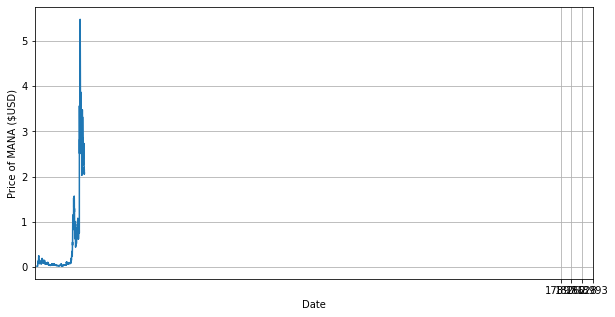

In [6]:
# Define some x-ticks to label the dates
t = [
 datetime.strptime('19-01','%y-%m'),
 datetime.strptime('20-01','%y-%m'),
 datetime.strptime('21-01','%y-%m'),
 datetime.strptime('22-01','%y-%m'),
]

# Plot the price of MANA in $USD
plt.figure(figsize=(10,5))
plt.plot(mana_price.index.values, mana_price.Close.values)
plt.xticks(t)
plt.xlabel('Date')
plt.ylabel('Price of MANA ($USD)')
plt.grid('on')

ValueError: x and y must have same first dimension, but have shapes (1622,) and (1219,)

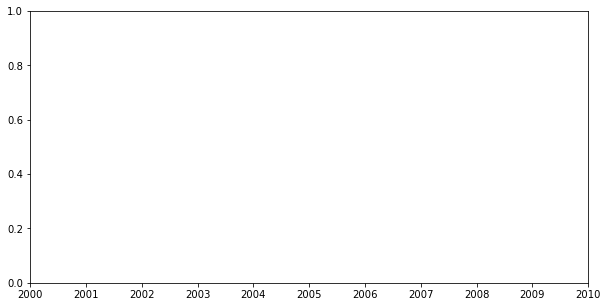

In [105]:
# Plot the transaction volume of parcels
plt.figure(figsize=(10,5))
plt.plot(mana_price.index.values, number_sold.values)
plt.xticks(t)
plt.xlabel('Date')
plt.ylabel('Transaction volume (parcels)')
plt.grid('on')

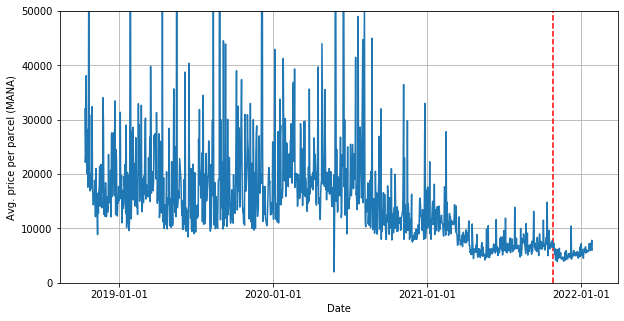

In [285]:
# Plot Average price per parcel in MANA
# Price of parcels seem to decrease with time,
# but this could be because MANA is becoming more expensive
plt.figure(figsize=(10,5))
plt.plot(mana_price.index.values, mana_price.price.values)
plt.xticks(t)
plt.xlabel('Date')
plt.ylabel('Avg. price per parcel (MANA)')
plt.grid('on')
plt.ylim((0,50000))
plt.vlines(x=datetime.strptime('21-10-28','%y-%m-%d'),ymin=0,ymax=60000,color='r', linestyle='--')

(0, 40000)

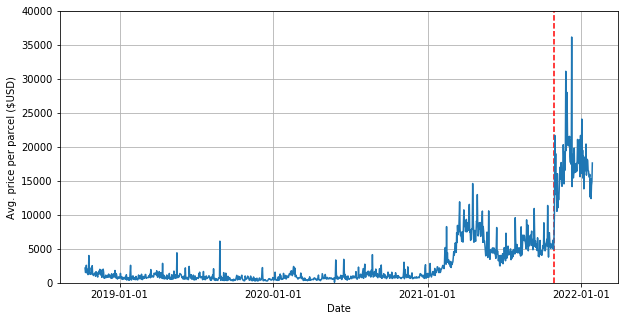

In [286]:
# Plot the average price per parcel in $USD
# This shows how parcels are being valued in terms of fiat currency
# The real price of parcels is trending up
# red dashed line corresponds to the time Facebook announced Meta
plt.figure(figsize=(10,5))
plt.plot(mana_price.index.values, mana_price.price.values*mana_price.Close.values)
plt.xticks(t)
plt.xlabel('Date')
plt.ylabel('Avg. price per parcel ($USD)')
plt.grid('on')
plt.vlines(x=datetime.strptime('21-10-28','%y-%m-%d'),ymin=0,ymax=60000,color='r', linestyle='--')
plt.ylim(0,40000)

In [52]:
# Read downloaded data from parcel_transactions.csv
ownerships = pd.read_csv('decentraland_ownership.csv')
owners = ownerships.owner.value_counts().index[0:10]
land = ownerships.owner.value_counts().values[0:10]
short = owners.to_series().apply(lambda a: a[0:5])

Text(0.5, 0, 'Owner')

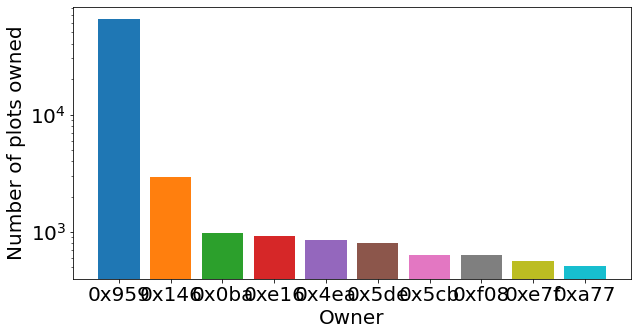

In [53]:
# Plot amount of parcels owned by top 10 land owners 
mpl.rcParams.update({'font.size':20})
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.bar(short,land,color=colors)
plt.yscale('log')
plt.ylabel('Number of plots owned')
plt.xlabel('Owner')

/opt/conda/envs/data3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/data3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/data3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/

(-150.0, 150.0, -165.0, 165.0)

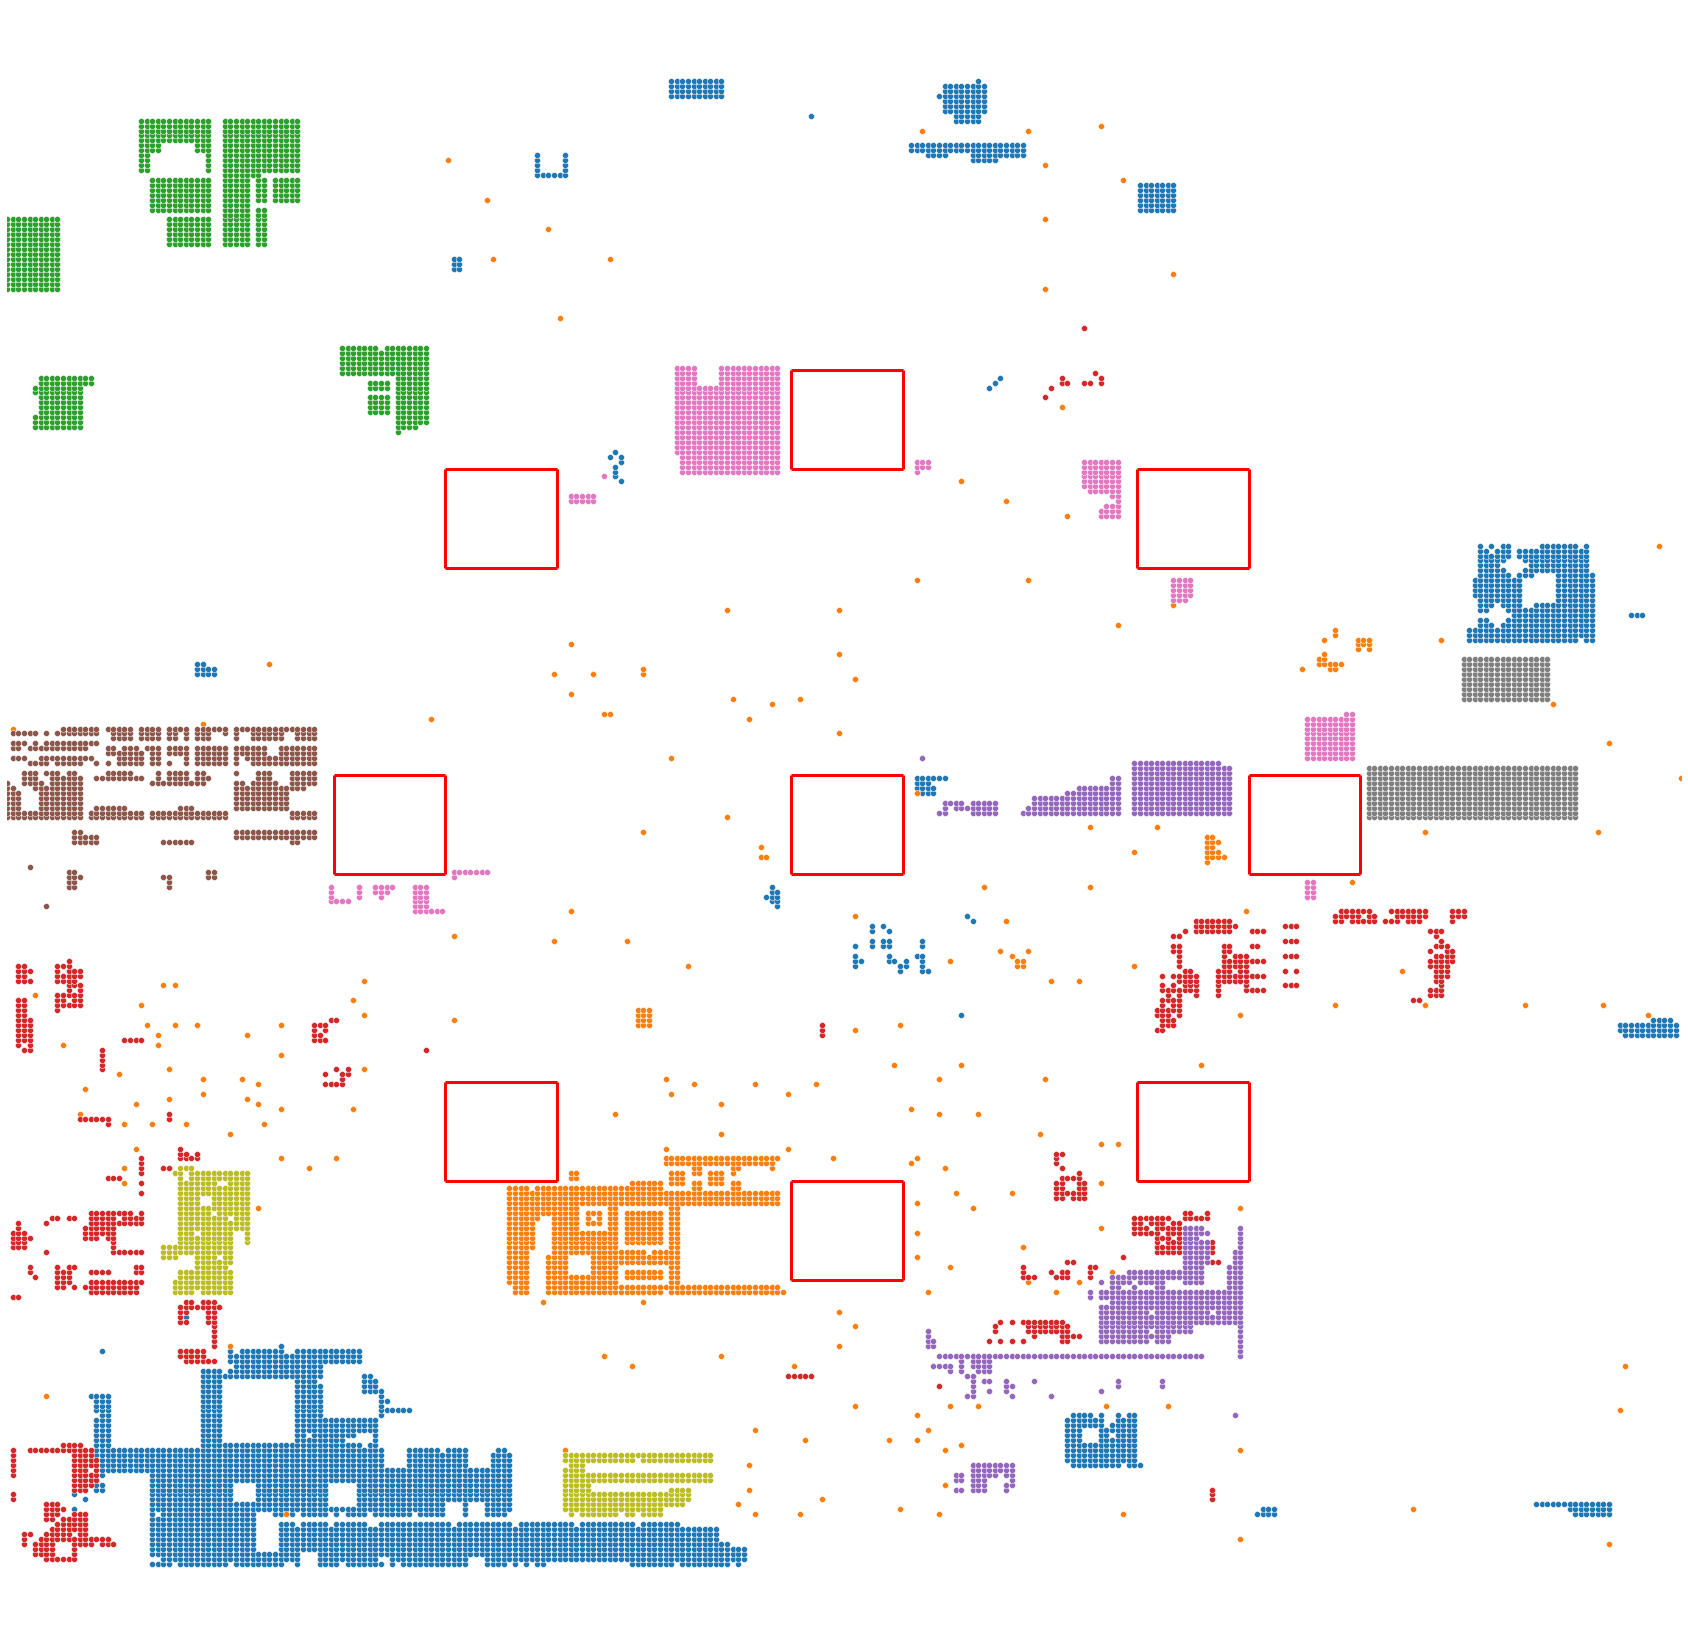

In [54]:
def plot_plaza(center_x, center_y, sq_size, color='r'):
    center_x += 0.5
    center_y -= 0.5
    plt.hlines(y= center_y -sq_size, xmin= center_x -sq_size, xmax= center_x + sq_size, color=color, linestyle='-', linewidth = 3)
    plt.vlines(x= center_x -sq_size, ymin= center_y -sq_size, ymax= center_y + sq_size, color=color, linestyle='-', linewidth = 3)
    plt.hlines(y= center_y +sq_size, xmin= center_x -sq_size, xmax= center_x + sq_size, color=color, linestyle='-', linewidth = 3)
    plt.vlines(x= center_x +sq_size, ymin= center_y -sq_size, ymax= center_y + sq_size, color=color, linestyle='-', linewidth = 3)

# Plot areas owned by top 10 landowners
plt.figure(figsize=(30,30))
for i in range(1,10):
    sns.scatterplot(ownerships.x[ownerships.owner == ownerships.owner.value_counts().index[i]], ownerships.y[ownerships.owner == ownerships.owner.value_counts().index[i]])

# Plotting the locations of the high footfall plazas    
plot_plaza(0,0,10)
plot_plaza(82,0,10)
plot_plaza(0,82,10)
plot_plaza(-82,0,10)
plot_plaza(0,-82,10)
plot_plaza(62,62,10)
plot_plaza(62,-62,10)
plot_plaza(-62,62,10)
plot_plaza(-62,-62,10)
plt.xlim(-150,150)
plt.axis('off')

In [7]:
# Read downloaded data from parcel_transactions.csv
transactions = pd.read_csv('parcel_transactions.csv')

In [8]:
last_sold = transactions.iloc[transactions.groupby('parcel_id').updatedAt.idxmax().values]

In [57]:
price_map = last_sold.pivot("y", "x", "price")

/tmp/ipykernel_36/3434477860.py:4: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


Text(0, 0.5, 'Price(MANA)')

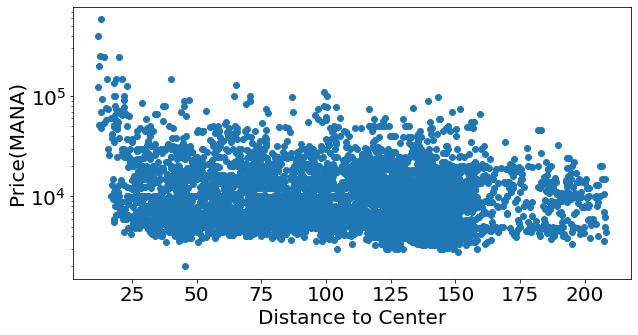

In [58]:
plt.figure(figsize=(10,5))
radius = np.sqrt(last_sold.x**2 + last_sold.y**2)
plt.scatter(radius,last_sold.price)
plt.yscale('Log')
plt.xlabel('Distance to Center')
plt.ylabel('Price(MANA)')

In [59]:
def plot_plazas(x,y,sq_size, color='r'):
    plot_plaza(x+0,y+0,10, color = color)
    plot_plaza(x+82,y+0,10, color = color)
    plot_plaza(x+0,y+82,10, color = color)
    plot_plaza(x-82,y+0,10, color = color)
    plot_plaza(x+0,y-82,10, color = color)
    plot_plaza(x+62,y+62,10, color = color)
    plot_plaza(x+62,y-62,10, color = color)
    plot_plaza(x-62,y+62,10, color = color)
    plot_plaza(x-62,y-62,10, color = color)

In [ ]:
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map, norm=LogNorm(), square = True, vmin=2000, vmax=80000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of parcels (MANA)")

plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
ticks = np.array([2000., 4000., 10000., 20000., 40000., 80000.])
ticklabels = ["{:.0f}k".format(x) for x in ticks/1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
#plt.axis('off')

In [30]:
def MANA_to_USD(mana_price, date):
    return float(mana_price[mana_price.Date == date].Close)

In [29]:
def convert_to_USD(row):
    return MANA_to_USD(mana_price, row.updatedAt_dt) * row.price

In [32]:
#last_sold['price_usd'] 
test= last_sold.apply(convert_to_USD, axis='columns')

In [33]:
test

3876     1548.063600
7632    39332.260825
8940    19250.279224
2909      809.550000
2908      809.550000
            ...     
7734    44021.084592
3561     1594.023300
4595      616.920000
9280    14023.196050
8251    23315.836320
Length: 5966, dtype: float64

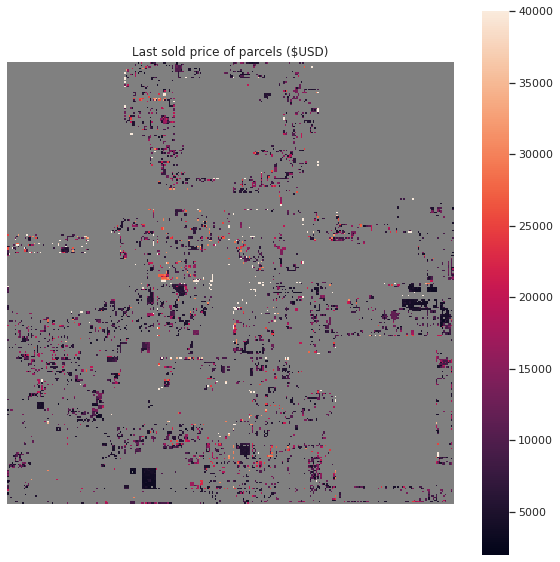

In [251]:
price_map_usd = last_sold.pivot("y", "x", "price")
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map_usd, square = True, vmin=2000, vmax=40000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of parcels ($USD)")

#plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
#ticks = np.array([200., 1000., 2000., 10000., 20000., 80000.])
#ticklabels = ["${}k".format(x) for x in ticks/1000]
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(ticklabels)

#plt.axis('off')

(-150.0, 150.0, -165.0066777041943, 165.0066777041943)

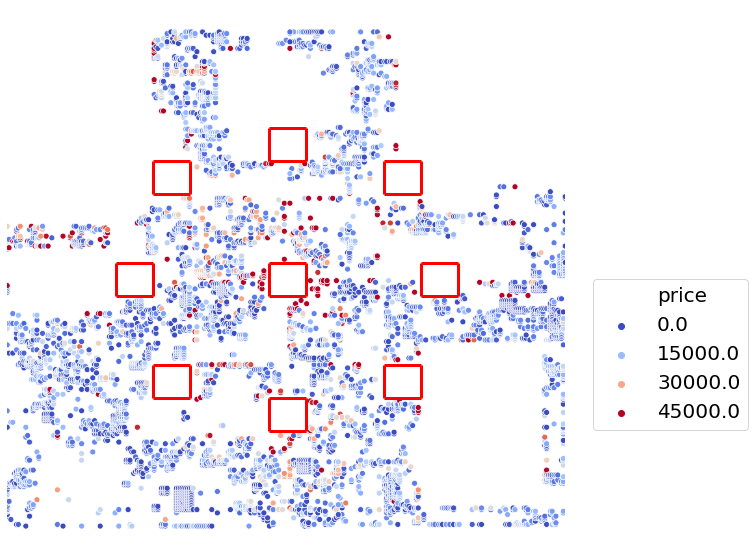

In [974]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(data = last_sold, x="x", y="y",  hue=last_sold.price, palette = "coolwarm", hue_norm =(5000,40000), norm=LogNorm())
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
plt.axis('off')
plot_plaza(0,0,10)
plot_plaza(82,0,10)
plot_plaza(0,82,10)
plot_plaza(-82,0,10)
plot_plaza(0,-82,10)
plot_plaza(62,62,10)
plot_plaza(62,-62,10)
plot_plaza(-62,62,10)
plot_plaza(-62,-62,10)
plt.xlim(-150,150)
plt.axis('off')

In [9]:
# Read downloaded data from parcel_transactions.csv
estate_transactions = pd.read_csv('estate_transactions.csv')

In [150]:
estate_transactions

,category,price,id,buyer,updatedAt,nft,updatedAt_dt,parcels,estate_id
0,estate,100000.0,0xfa823daaf8ce6d40950d95fa407151b9d64e17e717e5...,0x0f08f5cf0905498ac6a8b5ff3d4c2acb5ff447f7,1539280016,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-11,"[(-100, -107), (-99, -107)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1,estate,100000.0,0xf52546e4d2fd7701ef16a36e199b596201fdc6066009...,0xef38f892e4722152fd8edb50cd84a96344fd47ce,1539280356,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-11,"[(-100, -107), (-99, -107)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
2,estate,525000.0,0x0910cb1099a4e8a33e153b74aabfd9e5541c0ecde78b...,0x11f961e66bae258b09bf844b237447a973a960e8,1539350213,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-12,"[(40, 64), (40, 65), (40, 66), (40, 67), (40, ...",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
3,estate,99000.0,0xd70c22996842eb0e9898d604a5f9c6cbe54b9fea26a7...,0x0ed1c03d04c1fbb33a0f25ef6147ab5a73d811a7,1539364639,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-12,[],estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
4,estate,33999.0,0xc166dc81d57408d3f78561d23a628bf203d873c82e62...,0xf902d068920234957d2908b8b0156e61c0bea2c2,1539372861,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-12,[],estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
...,...,...,...,...,...,...,...,...,...
1903,estate,22300.0,0x7f428392c8b2db2003f5edf192303c59a44f8607fc1f...,0x4a1bf5d5f3a824c4353614369451d5233d4d6f06,1649434093,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-08,"[(-120, -31), (-120, -30), (-119, -31), (-119,...",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1904,estate,30000.0,0x3c3da8a06997c91ed16a3a9ecce26f4df2d3a9be7599...,0x1f5da4278ffdf8d816da17316b00b239976d8232,1649436497,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-08,"[(-27, 27), (-27, 28), (-26, 27), (-26, 28)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1905,estate,37000.0,0x7bbe02297d70b9826d455e6dc3b152358735a6e84b4c...,0x24167305a3667023ea565f971d72509ef758ac78,1649490240,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-09,"[(43, 82), (43, 83), (44, 82), (44, 83)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1906,estate,9888.0,0x150227fd63584b870d1a375855bf13c6f0972304a100...,0x5ce213893956bbf4249a7f8a079331280065eec6,1649642512,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-11,"[(-127, 10), (-126, 10)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...


In [446]:
last_sold_estate = estate_transactions.iloc[estate_transactions.groupby('estate_id').updatedAt.idxmax().values]
last_sold_estate = last_sold_estate[last_sold_estate.parcels != '[]']

In [468]:
def get_parcels(row):
    estate_parcel_coords_str = row.parcels
    parcels = [x.strip("[()] ") for x in estate_parcel_coords_str.split("),")]
    estate_parcel_coords = [(int(s.split(',')[0]), int(s.split(',')[1])) for s in parcels]
    parcel_breakdown_df = pd.DataFrame(columns=['estate_id','x','y','estate_size','total_price','price','updatedAt','updatedAt_dt','buyer'])

    for coord in estate_parcel_coords:
        entry = {
            'estate_id':row.estate_id, 
            'x':coord[0], 
            'y':coord[1], 
            'estate_size': len(estate_parcel_coords), 
            'total_price': row.price,
            'price': row.price/len(estate_parcel_coords),
            'updatedAt': row.updatedAt,
            'updatedAt_dt': row.updatedAt_dt,
            'buyer': row.buyer
        }
        parcel_breakdown_df = parcel_breakdown_df.append(entry, ignore_index=True)
    return parcel_breakdown_df

In [680]:
parcel_breakdown = pd.DataFrame(columns=['estate_id','x','y','estate_size','total_price','price','updatedAt','updatedAt_dt','buyer'])
i = 1
for index, row in last_sold_estate.iterrows():
    parcel_breakdown = parcel_breakdown.append(get_parcels(row), ignore_index=True)
    if (i % 100 == 0):
        print('first {} rows done!'.format(i))
    i = i+1

first 100 rows done!
first 200 rows done!
first 300 rows done!
first 400 rows done!
first 500 rows done!
first 600 rows done!
first 700 rows done!
first 800 rows done!


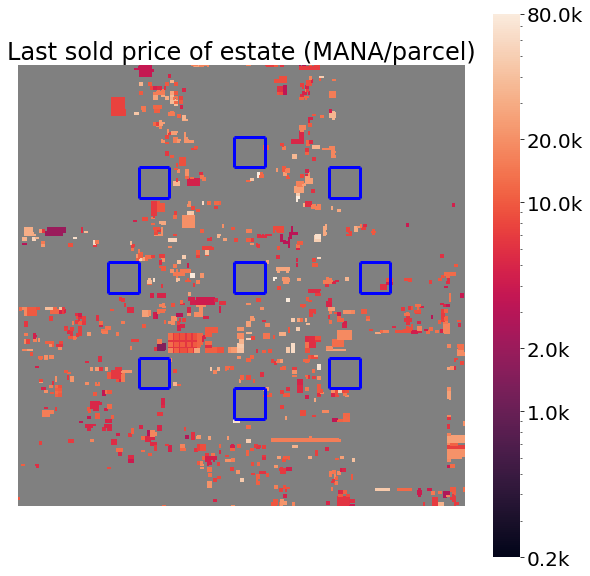

In [684]:
price_map_mana = parcel_breakdown.pivot("y", "x", "price")
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map_mana, norm=LogNorm(), square = True, vmin=200, vmax=80000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of estate (MANA/parcel)")

plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
ticks = np.array([200., 1000., 2000., 10000., 20000., 80000.])
ticklabels = ["{}k".format(x) for x in ticks/1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)


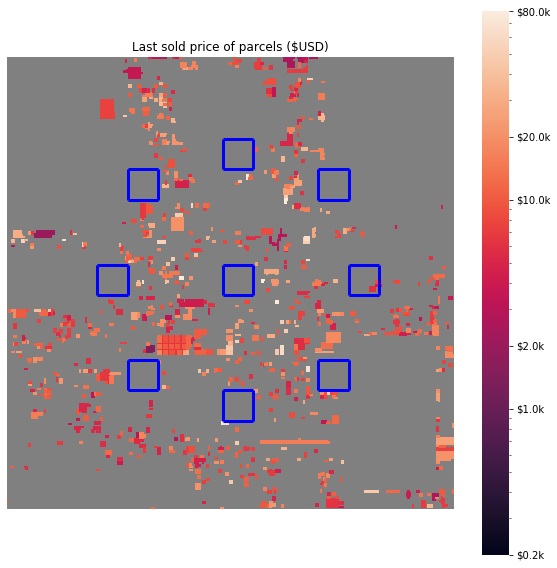

In [651]:
parcel_breakdown['price_usd'] = parcel_breakdown.apply(convert_to_USD, axis='columns')
price_map_usd = parcel_breakdown.pivot("y", "x", "price")
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map_mana, norm=LogNorm(), square = True, vmin=200, vmax=80000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of parcels ($USD)")

plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
ticks = np.array([200., 1000., 2000., 10000., 20000., 80000.])
ticklabels = ["${}k".format(x) for x in ticks/1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

In [34]:
from datetime import datetime
datetime.fromtimestamp(1539287969).strftime("%A, %B %d, %Y %I:%M:%S")


'Thursday, October 11, 2018 07:59:29'

In [96]:
cleaned_transactions = pd.DataFrame({'parcel_id': transactions.parcel_id,
                                     'category': transactions.category, 
                                     'price': transactions.price,
                                     'updatedAt': transactions.updatedAt,
                                     'updatedAt_dt': transactions.updatedAt_dt.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')),
                                     'owner': transactions.owner,
                                     'x': transactions.x,
                                     'y': transactions.y 
                                    })

In [97]:
price_usd = transactions.apply(convert_to_USD, axis='columns')

In [98]:
cleaned_transactions['price_usd'] = price_usd

In [70]:
transactions

,Unnamed: 0,category,status,price,id,updatedAt,nft,owner,name,estate,parcel,updatedAt_dt,x,y,parcel_id
0,0,parcel,sold,32000.0,0xbc79ff3843d8678425df0e8b0a7b1a67688720b78a8b...,1539287969,{'owner': {'id': '0x959e104e1a4db6317fa58f8295...,0x959e104e1a4db6317fa58f8295f586e1a978c297,NEAR VEGAS CITY - fordcotterill18@gmail.com,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-11,-70,145,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
1,1,parcel,sold,30000.0,0x3b2e69fe4806f1bf72aa060681c5d46e58952339854c...,1539329807,{'owner': {'id': '0x8668272b4776c423dde82314d5...,0x8668272b4776c423dde82314d5e0447fd4654aff,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,-27,-21,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
2,2,parcel,sold,15000.0,0x487340425511b41b2bbda39af565b4c9d74bb1157209...,1539334568,{'owner': {'id': '0x95606705b7452e96a9e88901ee...,0x95606705b7452e96a9e88901ee418ef4e3d19847,Peet's Place,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,65,-28,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
3,3,parcel,sold,15999.0,0x8e42e12fab25f618671e7f61a7c48bcce4bf5f790969...,1539337159,{'owner': {'id': '0x1bdd4874e4be949dfd237ca97e...,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,Coodz house,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,-44,101,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
4,4,parcel,sold,20000.0,0x9463c0aceb0c5f0a4884eedef9a2c03763b051ba5584...,1539344152,{'owner': {'id': '0x8e190b487e64ebab9cbc400a0d...,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,Excellent land sat right on Dragon city district!,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,84,-139,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9542,542,parcel,sold,7900.0,0xf66d10e381b96b7904d7ec8e95e56e31d60889f8e544...,1649793558,{'owner': {'id': '0x3dea6c7bc613c926e139e61432...,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-12,19,17,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9543,543,parcel,sold,5555.0,0x2e9a033401a12c33e14e08f6a89f0098b6be35d9c7af...,1649813981,{'owner': {'id': '0xefe0821cbb22716a906aa602b9...,0xefe0821cbb22716a906aa602b97810c4cc78a631,NISOVERSE,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,149,-69,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9544,544,parcel,sold,3950.0,0x2078af98ae35ca2dbe302734e3defd59e2eb039c3618...,1649816999,{'owner': {'id': '0x7823365ab55d6cefac58a08756...,0x7823365ab55d6cefac58a08756d1732892e4c933,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,120,-5,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9545,545,parcel,sold,4850.0,0x8fb303abece9ba2e129bddf88a424a000c23e140792d...,1649821339,{'owner': {'id': '0x1b81925e7f9ee7fa226d5a50bf...,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,128,-36,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...


In [100]:
cleaned_transactions

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000
...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,2022-04-12,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,17013.724400
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,2022-04-13,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,12228.143730
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,2022-04-13,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,8695.079700
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,2022-04-13,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,10676.237100


TypeError: strptime() argument 1 must be str, not Series

In [95]:
datetime(2020,1,1)

datetime.datetime(2020, 1, 1, 0, 0)

In [104]:
cleaned_transactions[cleaned_transactions.updatedAt_dt < datetime(2019,1,1)]

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000
...,...,...,...,...,...,...,...,...,...
1228,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1546248883,2018-12-31,0x959e104e1a4db6317fa58f8295f586e1a978c297,111,-2,908.440000
1229,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,9500.0,1546259615,2018-12-31,0x34b6d86fba8e66ca07438298c59e77e74e321604,146,-30,431.509000
1230,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,9900.0,1546268377,2018-12-31,0x34b6d86fba8e66ca07438298c59e77e74e321604,146,-30,449.677800
1231,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,9550.0,1546270546,2018-12-31,0xba19945798d02e0441b2d1c3ecfdee84b3e32683,145,-30,433.780100


Text(0, 0.5, '# sales per month')

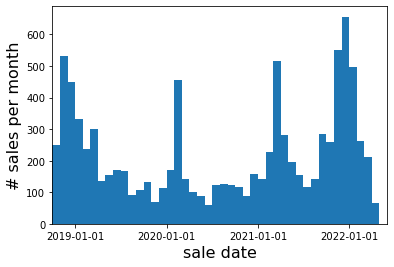

In [126]:
db = [datetime(y,m,1)  for y in [2017,2018,2019,2020,2021,2022] for m in range(1,13)]
plt.hist(cleaned_transactions.updatedAt_dt,bins=db)
plt.xlim(datetime(2018,10,1),datetime(2022,6,1))
plt.xticks([datetime(y,1,1)  for y in [2019,2020,2021,2022]])
plt.xlabel('sale date', fontsize=16)
plt.ylabel('# sales per month', fontsize=16)

In [127]:
def calculate_dist(X0, X1):
    '''
    This function takes a list of subject coords of parcels X1 and 
    returns the nearest distance to a list of coords of target parcels X0
    e.g. calculate_dist(road_parcels, sold_parcels)
    '''
    neigh = NearestNeighbors(n_neighbors=1, radius=10.0, algorithm = 'kd_tree')
    neigh.fit(X0)
    dist, _ = neigh.kneighbors(X1)
    return dist
    

from sklearn.neighbors import NearestNeighbors
road_parcels = [i for i in zip(roads.x, roads.y)]
genesis_parcels = [i for i in zip(genesis.x, genesis.y)]
sold_parcels_xy = [i for i in zip(cleaned_transactions.x, cleaned_transactions.y)]
cleaned_transactions['dist_road'] = calculate_dist(road_parcels, sold_parcels_xy)
cleaned_transactions['dist_genesis'] = calculate_dist(genesis_parcels, sold_parcels_xy)
cleaned_transactions['dist_center'] = np.sqrt(np.sum(np.array(sold_parcels_xy)**2,1))


In [128]:
cleaned_transactions

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd,dist_road,dist_genesis,dist_center
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000,2.000000,74.000000,161.012422
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000,18.867962,39.824616,34.205263
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000,12.206556,20.248457,70.774289
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721,7.000000,31.048349,110.168053
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000,11.000000,69.231496,162.409975
...,...,...,...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,2022-04-12,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,17013.724400,9.219544,48.104054,25.495098
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,2022-04-13,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,12228.143730,1.000000,78.000000,164.201096
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,2022-04-13,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,8695.079700,4.000000,29.000000,120.104121
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,2022-04-13,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,10676.237100,2.000000,45.803930,132.966161


In [151]:
x, y = np.linspace(-150,150,301), np.linspace(-150,150,301)
X,Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
R = np.sqrt(X**2 + Y**2)

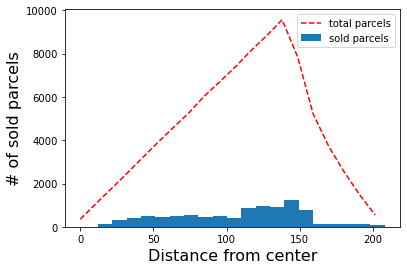

In [195]:
norm = np.histogram(R,bins=20)
plt.hist(cleaned_transactions.dist_center,bins=20)
plt.xlabel('Distance from center', fontsize=16)
plt.ylabel('# of sold parcels', fontsize=16)
plt.plot(norm[1][:-1],norm[0],'r--')
plt.legend(['total parcels','sold parcels'])
#plt.yscale('log')

Text(0, 0.5, '# of sold parcels')

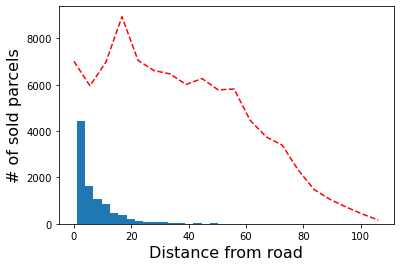

In [193]:
norm_roads = calculate_dist(road_parcels, [i for i in zip(X,Y)])
norm = np.histogram(norm_genesis_dist,bins=20)
plt.plot(norm[1][:-1], norm[0], 'r--')
plt.hist(cleaned_transactions.dist_road,bins=20)
plt.xlabel('Distance from road', fontsize=16)
plt.ylabel('# of sold parcels', fontsize=16)
#plt.yscale('log')

Text(0, 0.5, '# of sold parcels')

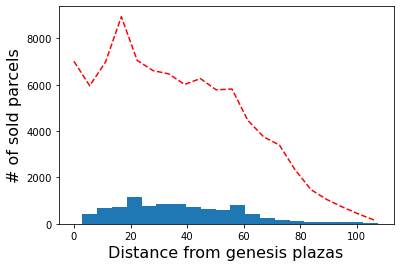

In [191]:
norm_genesis_dist = calculate_dist(genesis_parcels, [i for i in zip(X,Y)])
norm = np.histogram(norm_genesis_dist,bins=20)
plt.plot(norm[1][:-1], norm[0], 'r--')
plt.hist(cleaned_transactions.dist_genesis,bins=20)
plt.xlabel('Distance from genesis plazas', fontsize=16)
plt.ylabel('# of sold parcels', fontsize=16)

In [198]:
import seaborn as sns
sns.set()

In [209]:
cleaned_transactions

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd,dist_road,dist_genesis,dist_center
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000,2.000000,74.000000,161.012422
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000,18.867962,39.824616,34.205263
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000,12.206556,20.248457,70.774289
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721,7.000000,31.048349,110.168053
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000,11.000000,69.231496,162.409975
...,...,...,...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,2022-04-12,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,17013.724400,9.219544,48.104054,25.495098
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,2022-04-13,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,12228.143730,1.000000,78.000000,164.201096
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,2022-04-13,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,8695.079700,4.000000,29.000000,120.104121
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,2022-04-13,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,10676.237100,2.000000,45.803930,132.966161


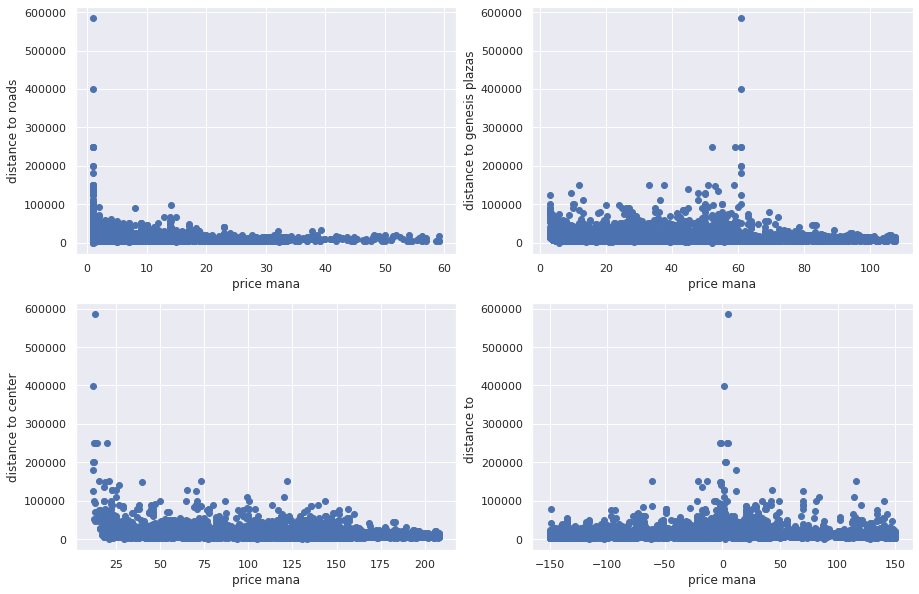

In [232]:
rows, cols = 2, 2
fig, axs = plt.subplots(rows, cols, figsize=(15,10))
axs[0,0].scatter(cleaned_transactions.dist_road, cleaned_transactions.price)
axs[0,1].scatter(cleaned_transactions.dist_genesis, cleaned_transactions.price)
axs[1,0].scatter(cleaned_transactions.dist_center, cleaned_transactions.price)
axs[1,1].scatter(cleaned_transactions.y, cleaned_transactions.price)
feature = ['roads', 'genesis plazas', 'center', '']
for i in range(rows):
    for j in range(cols):
        #axs[i, j].set_yscale('log')
        axs[i, j].set_ylabel(f'distance to {feature[i*2 + j]}')
        axs[i, j].set_xlabel('price mana')

In [233]:
y = cleaned_transactions.price

In [234]:
X = cleaned_transactions[['x','y','dist_road','dist_genesis']]

In [235]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr = LinearRegression()  # make an instance of the model 
lr.fit(X_train, y_train)             # fit the model

y_pred = lr.predict(X_test)


In [236]:
lr.score(X_train, y_train)

0.03618190323888015

In [237]:
lr.score(X_test, y_test)

0.025448986677101382

In [138]:
from sklearn import metrics

print("Mean absolute error:", metrics.mean_absolute_error(y, y_pred))
print("Mean squared error:", metrics.mean_squared_error(y, y_pred))
print("R^2:", metrics.r2_score(y, y_pred))

Mean absolute error: 4038.588389756491
Mean squared error: 53969305.384335466
R^2: 0.3682229945672192


In [122]:
cleaned_transactions

,parcel_id,category,price,updatedAt,owner,x,y,dist_road,dist_genesis,price_usd
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2.000000,74.000000,2166.304000
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,18.867962,39.824616,2048.370000
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,12.206556,20.248457,1024.185000
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,7.000000,31.048349,1092.395721
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,11.000000,69.231496,1365.580000
...,...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,9.219544,48.104054,17013.724400
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,1.000000,78.000000,12228.143730
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,4.000000,29.000000,8695.079700
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,2.000000,45.803930,10676.237100


In [53]:
transactions

,Unnamed: 0,category,status,price,id,updatedAt,nft,owner,name,estate,parcel,updatedAt_dt,x,y,parcel_id
0,0,parcel,sold,32000.0,0xbc79ff3843d8678425df0e8b0a7b1a67688720b78a8b...,1539287969,{'owner': {'id': '0x959e104e1a4db6317fa58f8295...,0x959e104e1a4db6317fa58f8295f586e1a978c297,NEAR VEGAS CITY - fordcotterill18@gmail.com,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-11,-70,145,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
1,1,parcel,sold,30000.0,0x3b2e69fe4806f1bf72aa060681c5d46e58952339854c...,1539329807,{'owner': {'id': '0x8668272b4776c423dde82314d5...,0x8668272b4776c423dde82314d5e0447fd4654aff,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,-27,-21,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
2,2,parcel,sold,15000.0,0x487340425511b41b2bbda39af565b4c9d74bb1157209...,1539334568,{'owner': {'id': '0x95606705b7452e96a9e88901ee...,0x95606705b7452e96a9e88901ee418ef4e3d19847,Peet's Place,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,65,-28,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
3,3,parcel,sold,15999.0,0x8e42e12fab25f618671e7f61a7c48bcce4bf5f790969...,1539337159,{'owner': {'id': '0x1bdd4874e4be949dfd237ca97e...,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,Coodz house,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,-44,101,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
4,4,parcel,sold,20000.0,0x9463c0aceb0c5f0a4884eedef9a2c03763b051ba5584...,1539344152,{'owner': {'id': '0x8e190b487e64ebab9cbc400a0d...,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,Excellent land sat right on Dragon city district!,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,84,-139,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9542,542,parcel,sold,7900.0,0xf66d10e381b96b7904d7ec8e95e56e31d60889f8e544...,1649793558,{'owner': {'id': '0x3dea6c7bc613c926e139e61432...,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-12,19,17,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9543,543,parcel,sold,5555.0,0x2e9a033401a12c33e14e08f6a89f0098b6be35d9c7af...,1649813981,{'owner': {'id': '0xefe0821cbb22716a906aa602b9...,0xefe0821cbb22716a906aa602b97810c4cc78a631,NISOVERSE,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,149,-69,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9544,544,parcel,sold,3950.0,0x2078af98ae35ca2dbe302734e3defd59e2eb039c3618...,1649816999,{'owner': {'id': '0x7823365ab55d6cefac58a08756...,0x7823365ab55d6cefac58a08756d1732892e4c933,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,120,-5,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9545,545,parcel,sold,4850.0,0x8fb303abece9ba2e129bddf88a424a000c23e140792d...,1649821339,{'owner': {'id': '0x1b81925e7f9ee7fa226d5a50bf...,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,128,-36,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...


In [35]:
transactions['Unnamed: 0']

0         0
1         1
2         2
3         3
4         4
       ... 
9542    542
9543    543
9544    544
9545    545
9546    546
Name: Unnamed: 0, Length: 9547, dtype: int64

In [333]:
from time import sleep
while True:
     sleep(5*60)   

KeyboardInterrupt: 